In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [1]:
import tensorflow as tf
#tf.config.experimental.set_visible_devices([], "GPU")

import importlib
from userdiffusion import ode_datasets, unet, samplers, diffusion, config as cfg, train
from clu import checkpoint
importlib.reload(ode_datasets)
importlib.reload(unet)
importlib.reload(samplers)
importlib.reload(train)

import matplotlib.pyplot as plt
from matplotlib import rc
rc('animation', html='jshtml')
import jax.numpy as jnp
import numpy as np
import jax

2024-12-19 16:20:46.137501: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-19 16:20:46.157070: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734625246.181063   22810 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734625246.188498   22810 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-19 16:20:46.212990: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
import os
import pickle

username="finzi"
exp_name = "test_3"#"all_datasets_and_ic"
xid=0
workdir = "../../../out/diffusion-dynamics/pmlr-v202-finzi23a/runs/fitzhugh"

with tf.io.gfile.GFile(os.path.join(workdir,'config.pickle'), "rb") as f:
  config = pickle.load(f)
with tf.io.gfile.GFile(os.path.join(workdir,'data_std.pickle'), "rb") as f:
  data_std = pickle.load(f)
# appending the checkpoint folder
checkpoint_dir = os.path.join(workdir, "checkpoints")

# added the checkpoint
ckpt = checkpoint.MultihostCheckpoint(checkpoint_dir, {}, max_to_keep=2)


In [ ]:
#config.dataset="LorenzDataset"

In [3]:
config

attention: false
bs: 500
channels: 32
dataset: FitzHughDataset
dataset_timesteps: 60
difftype: VarianceExploding
ds: 4000
epochs: 10000
ic_conditioning: false
lr: 0.0001
noisetype: Identity
seed: 37

In [4]:
# config = cfg.get_config()
# config.ic_conditioning=False
# config.dataset='FitzHughDataset'

from jax import random

key = random.PRNGKey(config.seed)
# Construct the dataset
timesteps = 60
ds = getattr(ode_datasets, config.dataset)(N=config.ds + config.bs)
Zs = ds.Zs[config.bs:, :timesteps]  # pylint: disable=invalid-name
test_x = ds.Zs[:config.bs, :timesteps]
T_long = ds.T_long[:timesteps]  # pylint: disable=invalid-name
dataset = tf.data.Dataset.from_tensor_slices(Zs)
dataiter = dataset.shuffle(len(dataset)).batch(config.bs).as_numpy_iterator
assert Zs.shape[1] == timesteps

# initialize the model
x = test_x  # (bs, N, C)
modelconfig = unet.unet_64_config(
    x.shape[-1], base_channels=config.channels, attention=config.attention)
model = unet.UNet(modelconfig)
noise = getattr(diffusion, config.noisetype)
difftype = getattr(diffusion, config.difftype)(noise)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [02:58<00:00,  2.52it/s]
I0000 00:00:1734625471.031366   22810 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4249 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1a:00.0, compute capability: 8.6


In [5]:
dataloader= dataiter
x = next(dataloader())
t = np.random.rand(x.shape[0])
cond_fn = lambda x: (x[:, :3] if config.ic_conditioning else None)
key = random.PRNGKey(config.seed)
key, init_seed = random.split(key)
params = model.init(init_seed, x=x, t=t, train=False, cond=cond_fn(x))

In [6]:
ema_params = ckpt.restore(params)

In [7]:
def score(params,
            x,
            t,
            train,
            cond = None):
    """Score function with appropriate input and output scaling."""
    # scaling is equivalent to that in https://arxiv.org/abs/2206.00364
    sigma, scale = diffusion.unsqueeze_like(x, difftype.sigma(t), difftype.scale(t))
    input_scale = 1 / jnp.sqrt(sigma**2 + (scale * data_std)**2)
    cond = cond / data_std if cond is not None else None
    out = model.apply(params, x=x * input_scale, t=t, train=train, cond=cond)
    return out / jnp.sqrt(sigma**2 + scale**2 * data_std**2)

@jax.jit
def score_out(x,t,cond=None) -> jnp.ndarray:
  if not hasattr(t, 'shape') or not t.shape:
    t = jnp.ones(x.shape[0]) * t
  return score(ema_params, x, t, train=False, cond=cond)

score_fn = score_out
from functools import partial
eval_scorefn = partial(score_out,cond=cond_fn(test_x))

In [8]:
import pandas as pd
import numpy as np
import jax

In [9]:
diff =difftype
#sde_samples = samplers.sde_sample(diff, eval_scorefn, key, test_x.shape,nsteps=1000)
#ode_samples = samplers.discrete_ode_sample(diff, eval_scorefn, key, test_x.shape,nsteps=1000)

In [10]:
def lorenz_C(x):
    fourier_mag = jnp.abs(jnp.fft.rfft(x[...,0],axis=-1))
    return -(fourier_mag[...,1:].mean(-1)-.6)

def fitz_C(x):
    C = jnp.max(x[...,:2].mean(-1),-1)-2.5
    return C

def pendulum_C(x):
    raise NotImplementedError

constraints = {'FitzHughDataset':fitz_C,
          'LorenzDataset': lorenz_C,
          'NPendulumDataset':pendulum_C,
          }
event_constraint = constraints[config.dataset]

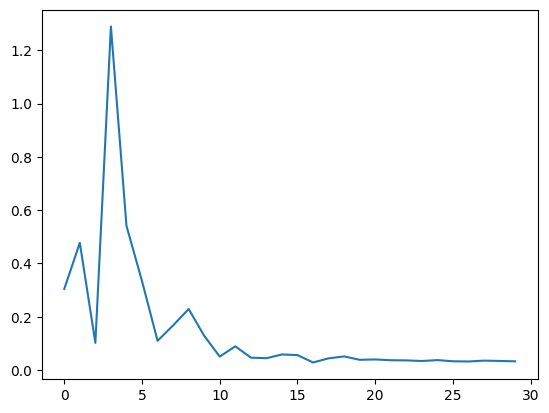

In [11]:
plt.plot(jnp.abs(jnp.fft.rfft(test_x[0,:,2]))[1:])

In [12]:
event_scores = samplers.event_scores(diff,score_fn, event_constraint, reg=1e-3)

In [13]:
sde_event_samples = samplers.sde_sample(diff, event_scores, key, test_x.shape,nsteps=1000)
#ode_event_samples = samplers.discrete_ode_sample(diff, event_scores, key, test_x.shape,nsteps=1000)

In [14]:
sde_samples = samplers.sde_sample(diff, score_fn, key, test_x.shape,nsteps=1000)
#ode_samples = samplers.discrete_ode_sample(diff, score_fn, key, test_x.shape,nsteps=1000)

In [15]:
T = ds.T_long[:timesteps]

In [16]:
event_distribution = event_constraint(Zs)
events_train = Zs[event_constraint(Zs)>0]
events_test = test_x[event_constraint(test_x)>0]

Text(0.5, 1.0, 'Example model events')

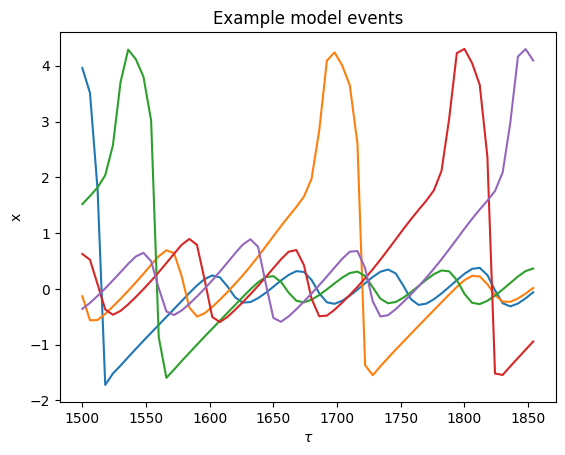

In [17]:
plt.plot(T,sde_samples[event_constraint(sde_samples)>0][:5,:,0].T)
plt.xlabel(r'$\tau$')
plt.ylabel('x')
plt.title('Example model events')

Text(0.5, 1.0, 'Data samples')

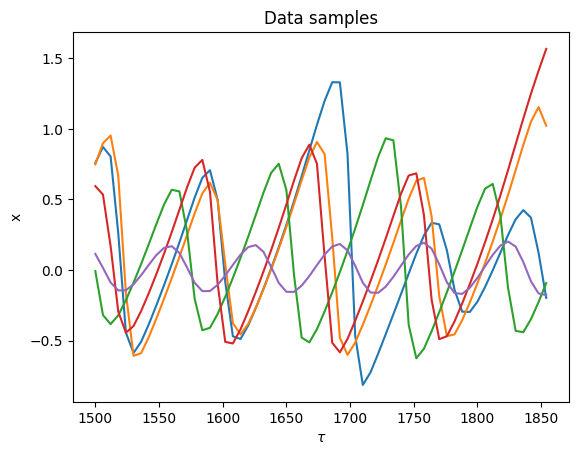

In [18]:
plt.plot(T,test_x[10:15,:,0].T)
plt.xlabel(r'$\tau$')
plt.ylabel('x')
plt.title('Data samples')

Text(0.5, 1.0, 'Example events in dataset')

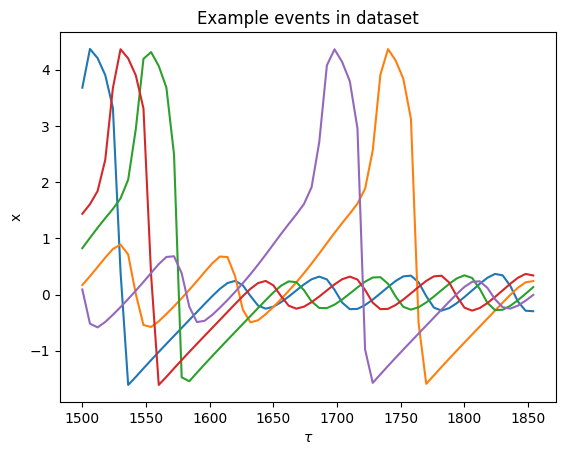

In [19]:
plt.plot(T,events_test[:5,:,0].T)
plt.xlabel(r'$\tau$')
plt.ylabel('x')
plt.title('Example events in dataset')

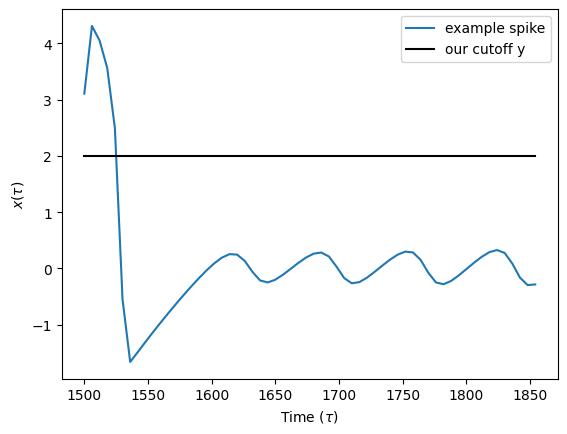

In [20]:
T = ds.T[:timesteps]
plt.plot(T,events_test[0,:,:2].mean(-1))
plt.plot(T,2*np.ones_like(T),color='k')
plt.xlabel(r'Time ($\tau$)')
plt.ylabel(r'$x(\tau)$')
plt.legend(['example spike', 'our cutoff y'])

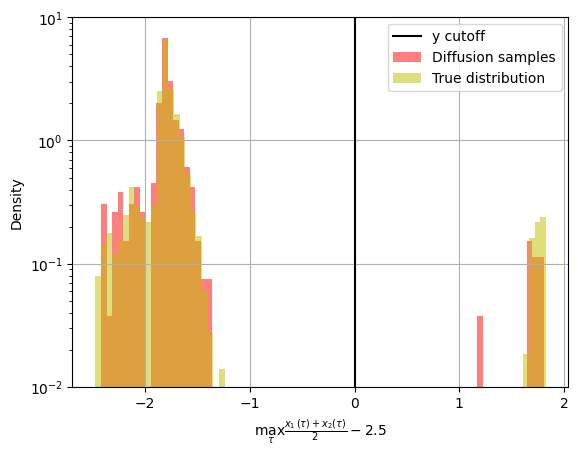

In [48]:
plt.hist(np.array(event_constraint(sde_samples)),bins=80,color='red',density=True,alpha=.5)
#plt.hist(np.array(ode_samples[:,:timesteps,:2].mean(-1).max(-1)),bins=100,color='g',density=True,alpha=.2)
plt.hist(np.array(event_constraint(ds.Zs[:4000,:timesteps])),bins=80,color='y',density=True,alpha=.5)

#plt.yscale('log')
#plt.xlabel(r'$\max_\tau x(\tau)$')
plt.xlabel(r'$\max_\tau \frac{x_1(\tau) + x_2(\tau)}{2} - 2.5$')
plt.ylabel('Density')
# plt.ylim(1e-2,2.5)

# Taos edits
plt.yscale('log')
plt.ylim(1e-2, 10)
plt.grid()

plt.axvline(x=0,color='k')
plt.legend(['y cutoff','Diffusion samples','True distribution'])

In [22]:
sde_event_samples.shape

(500, 60, 4)

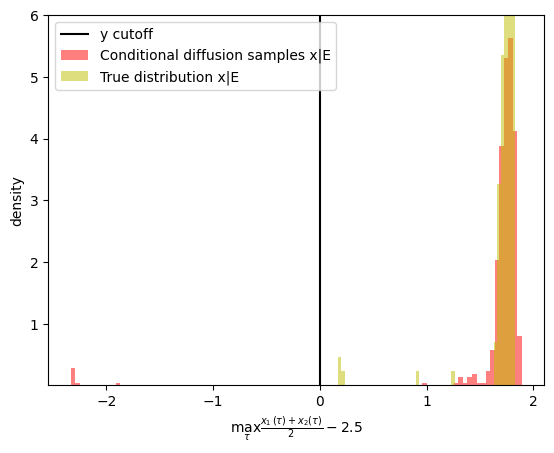

In [23]:
plt.hist(np.array(event_constraint(sde_event_samples[:,:])),bins=100,color='red',density=True,alpha=.5)
#plt.hist(np.array(ode_samples[:,:timesteps,:2].mean(-1).max(-1)),bins=100,color='g',density=True,alpha=.2)
plt.hist(np.array(event_constraint(events_train[:,:timesteps])),bins=50,color='y',density=True,alpha=.5)

#plt.yscale('log')
#plt.xlabel(r'$\max_\tau x(\tau)$')
plt.axvline(0,color='k')
plt.xlabel(r'$\max_\tau \frac{x_1(\tau) + x_2(\tau)}{2} - 2.5$')
plt.ylabel('density')
plt.ylim(1e-2,6)
plt.legend(['y cutoff','Conditional diffusion samples x|E','True distribution x|E'])

<Axes: ylabel='Density'>

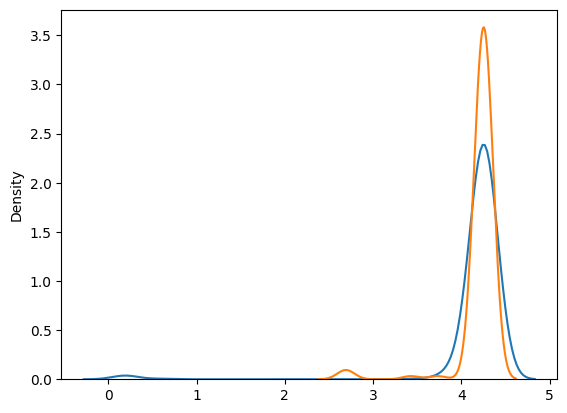

In [24]:
import seaborn
seaborn.kdeplot(np.array(sde_event_samples[:,:timesteps,:2].mean(-1).max(-1)))
seaborn.kdeplot(np.array(events_train[:,:timesteps,:2].mean(-1).max(-1)))

In [25]:
(event_constraint(sde_event_samples)>0).mean()

Array(0.984, dtype=float32)

Text(0.5, 1.0, 'x|E conditional model samples')

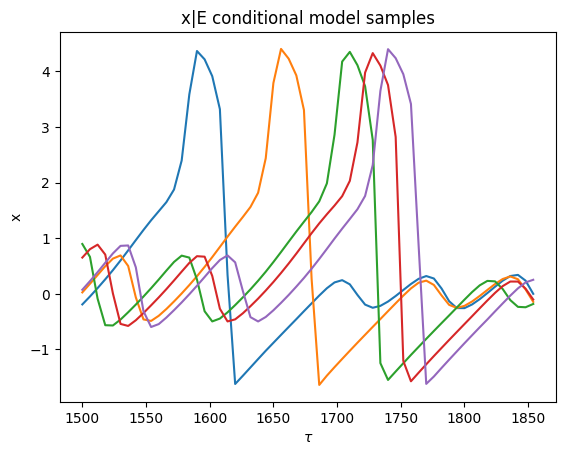

In [26]:
sde_events2 = sde_event_samples[event_constraint(sde_event_samples)>0,:,0]
plt.plot(T,sde_events2[:5].T)
plt.xlabel(r'$\tau$')
plt.ylabel('x')
plt.title('x|E conditional model samples')

In [27]:
ds.animate(sde_event_samples[event_constraint(sde_event_samples)>0][1])

AssertionError: too many dimensions for animation

In [ ]:
ds.animate(test_x[1])

In [28]:
(event_constraint(Zs)>0).mean()

Array(0.03225, dtype=float32)

In [29]:
jnp.exp(-10)

Array(4.539993e-05, dtype=float32, weak_type=True)

In [30]:
type((jnp.ones(3)*.2).sum())

jaxlib.xla_extension.ArrayImpl

In [31]:
logprob,logprob_std = samplers.marginal_logprob(diff, score_fn, event_constraint, test_x[0].shape,nsteps=1000)

Fraction of sampled which satisfy 1.0


In [33]:
conditional_likelihood = samplers.discrete_time_likelihood(diff, event_scores, sde_event_samples[:2])
unconditional_likelihood = samplers.discrete_time_likelihood(diff, score_fn, sde_event_samples[:2])
print(conditional_likelihood,unconditional_likelihood)

[1373.4186 1378.0438] [1374.7772 1377.4631]


In [34]:
print(logprob,logprob_std)

-7.414673 0.49288836


In [35]:
jnp.exp(-logprob)

Array(1660.166, dtype=float32)

In [36]:
# plt.plot(ode_event_samples[:5,:,:2].mean(-1).T)

NameError: name 'ode_event_samples' is not defined

In [37]:
#nll1 = samplers.compute_nll(diff,score_fn,key,sde_samples)
nll2 = -samplers.discrete_time_likelihood(diff,score_fn,sde_samples[:5])/sde_samples[0].size

In [38]:
nll2

Array([-6.774871 , -6.766704 , -6.8425193, -6.692491 , -6.7176304],      dtype=float32)

In [39]:
expanded = (mb[None]+jnp.zeros((10,1,1,1))).reshape(mb.shape[0]*10,*mb.shape[1:])#[:,slc]
predictions = samplers.sde_sample(diff,inpainting_scores2(diff,score_fn,expanded[:,slc],slc,scale=300.),key,expanded.shape,nsteps=2000,traj=False)

NameError: name 'mb' is not defined

In [40]:
sde_samples.shape

(500, 60, 4)

In [41]:
from jax import vmap
#
T = T_long
z1 = sde_samples
z2 = ode_samples
z_gts = test_x[:z1.shape[0]]
z0 = z_gts[:,0]#z_gts[:,0]
#z0 = test_x
#z_gts = vmap(ds.integrate,(0,None),0)(z0,T)
z_pert = vmap(ds.integrate,(0,None),0)(z0+1e-3*np.random.randn(*z0.shape),T)
z_random = vmap(ds.integrate,(0,None),0)(ds.sample_initial_conditions(z0.shape[0]),T)
for pred in [z1,z2,z_pert,z_random]:
  clamped_errs = jax.lax.clamp(1e-3,train.rel_err(pred,z_gts),np.inf)
  rel_errs = np.exp(jnp.log(clamped_errs).mean(0))
  rel_stds = np.exp(jnp.log(clamped_errs).std(0))
  plt.plot(T,rel_errs)
  plt.fill_between(T, rel_errs/rel_stds, rel_errs*rel_stds,alpha=.1)

plt.plot()
plt.yscale('log')
plt.xlabel('Time')
plt.ylabel('Prediction Error')
plt.legend(['SDE Diffusion Model Rollout','ode','1e-3 Perturbed GT','Random Init'])

NameError: name 'ode_samples' is not defined

In [42]:
from jax import vmap
#z_gts = test_x[:z1.shape[0]]
T = T_long
z = ode_samples
z0 = z[:,0]#z_gts[:,0]
#z0 = test_x
z_gts = vmap(ds.integrate,(0,None),0)(z0,T)
z_pert = vmap(ds.integrate,(0,None),0)(z0+1e-3*np.random.randn(*z0.shape),T)
z_random = vmap(ds.integrate,(0,None),0)(ds.sample_initial_conditions(z0.shape[0]),T)
for pred in [z,z_pert,z_random]:
  clamped_errs = jax.lax.clamp(1e-3,train.rel_err(pred,z_gts),np.inf)
  rel_errs = np.exp(jnp.log(clamped_errs).mean(0))
  rel_stds = np.exp(jnp.log(clamped_errs).std(0))
  plt.plot(T,rel_errs)
  plt.fill_between(T, rel_errs/rel_stds, rel_errs*rel_stds,alpha=.1)

plt.plot()
plt.yscale('log')
plt.xlabel('Time')
plt.ylabel('Prediction Error')
plt.legend(['SDE Diffusion Model Rollout','1e-3 Perturbed GT','Random Init'])

NameError: name 'ode_samples' is not defined

In [43]:
from flax.core.frozen_dict import FrozenDict
import numpy as np
def sum_params(params):
  if isinstance(params, (jax.numpy.ndarray,np.ndarray)):
    return params.sum()
  elif isinstance(params, (dict, FrozenDict)):
    return sum([sum_params(v) for v in params.values()])
  else:
    assert False, type(params)
print(sum_params(params))
print(sum_params(p2))

6636.449


NameError: name 'p2' is not defined

In [ ]:
type(None)

In [ ]:
type(p2)

In [ ]:
import jax.numpy as jnp
jnp.exp(973.3657-977.17847)